# Функции

In [1]:
import numpy as np

from scipy.stats import ks_2samp, chisquare


def k2(array_1, array_2):
    stat, p_value = ks_2samp(array_1, array_2)
    print(f"True frequency: {np.sum(array_1) / len(array_1.flatten())}")
    print(f"Predicted frequency: {np.sum(array_2) / len(array_2.flatten())}")
    print(f"KS-statistic: {stat:.4f}")
    print(f"P-value: {p_value:.8f}")
    if p_value < 0.05:
        print("Samples have different (p-value < 0.05).")
    else:
        print("The samples correspond to each other (p-value >= 0.05).")


def chi2_test(array_1, array_2):
    bins = np.linspace(min(array_1.min(), array_2.min()), max(array_1.max(), array_2.max()), 10)
    hist1, _ = np.histogram(array_1, bins=bins)
    hist2, _ = np.histogram(array_2, bins=bins)
    hist1, hist2 = process_arrays(hist1, hist2)
    chi_stat, p_value = chisquare(f_obs=hist1, f_exp=hist2)
    print(f'True frequency: {hist1}')
    print(f'Predicted frequency: {hist2}')
    print(f"chi-statistic: {chi_stat:.4f}")
    print(f"P-value: {p_value:.8f}")
    if p_value < 0.05:
        print("Samples have different (p-value < 0.05).")
    else:
        print("The samples correspond to each other (p-value >= 0.05).")
    

def count_white_pixel_frequency(image, block_size=256):
    height, width = image.shape
    white_pixel_frequencies = [] 

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            num_white_pixels = np.sum(block == 1)
            total_pixels = block_size * block_size
            frequency = num_white_pixels / total_pixels
            white_pixel_frequencies.append(frequency)
    
    return np.array(white_pixel_frequencies)

def process_arrays(arr1, arr2):
    i = 0
    n = len(arr1)
    while i < n:
        if arr1[i] == 0 or arr2[i] == 0:
            if i > 0:
                arr1[i - 1] += arr1[i]
                arr2[i - 1] += arr2[i]
            arr1 = np.delete(arr1, i)
            arr2 = np.delete(arr2, i)
            n -= 1
        else:
            i += 1
    
    return arr1, arr2

# Анализ метрик


In [2]:
import numpy as np

from PIL import Image


def load_mask(file_path):
    mask = Image.open(file_path).convert("L")  
    binary_mask = np.array(mask) > 0  
    return binary_mask.astype(int)  

def dice(true_mask, predicted_mask):
    intersection = np.sum(true_mask * predicted_mask)
    return (2. * intersection) / (np.sum(true_mask) + np.sum(predicted_mask))

true_mask = load_mask("check\\big_tlt_test_mask.png")
predicted_mask = load_mask("check\\big_tlt_check_250.png")

height, width = predicted_mask.shape
pixels = height*width

TP = np.sum((true_mask == 1) & (predicted_mask == 1))/pixels
FP = np.sum((true_mask == 0) & (predicted_mask == 1))/pixels
FN = np.sum((true_mask == 1) & (predicted_mask == 0))/pixels
TN = np.sum((true_mask == 0) & (predicted_mask == 0))/pixels


precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Dice: {dice(true_mask, predicted_mask):.4f}")

True Positives (TP): 0.12196166427047164
False Positives (FP): 0.0173240237765842
False Negatives (FN): 0.017687126442238136
True Negatives (TN): 0.843027185510706
Precision: 0.8756
Recall: 0.8733
F1-Score: 0.8745
IoU: 0.7770
Dice: 0.8745


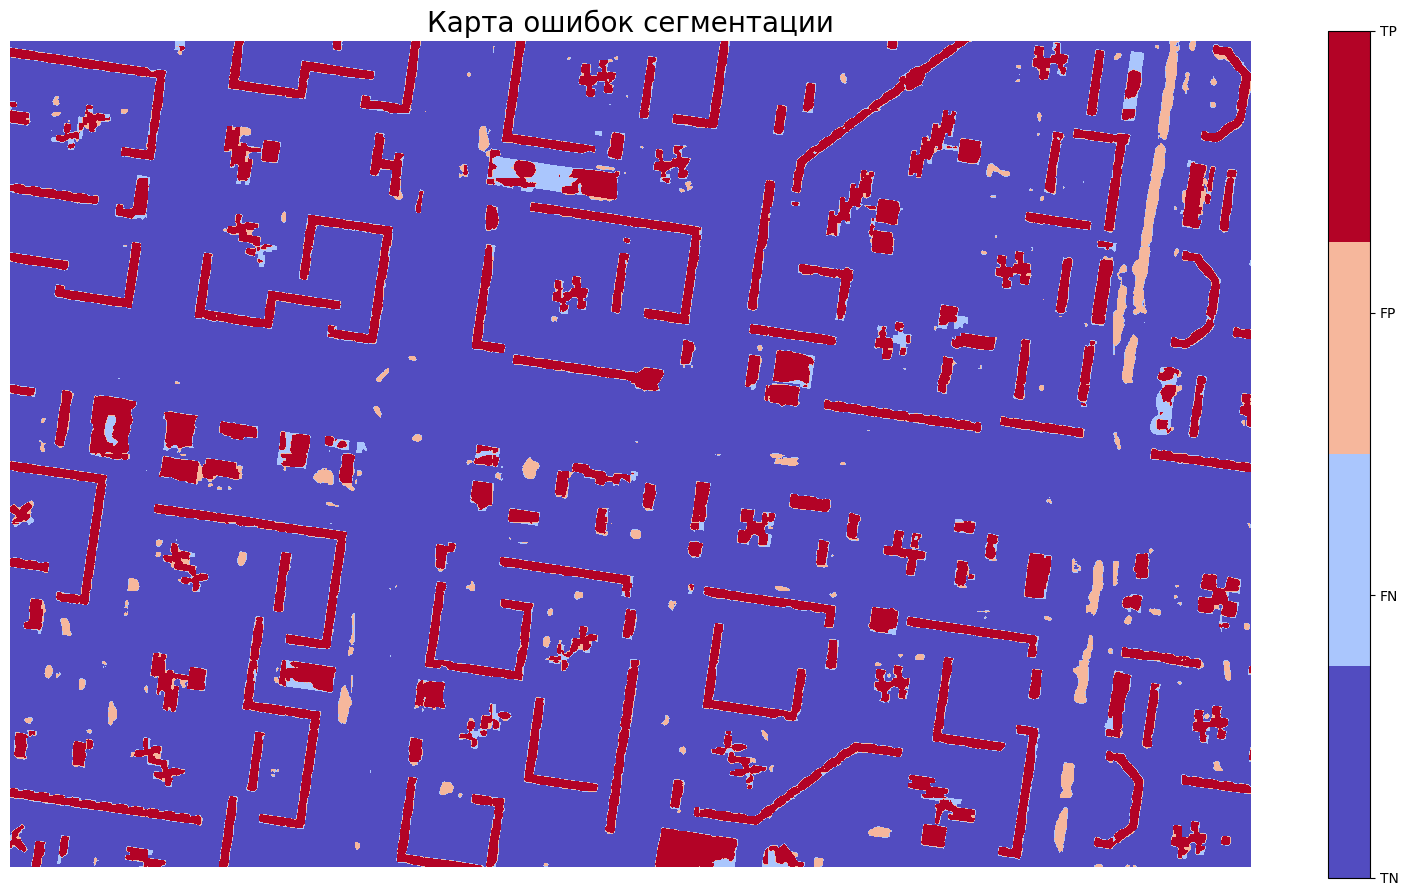

In [3]:
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap


error_map = np.zeros_like(true_mask, dtype=np.uint8)
error_map[(true_mask == 1) & (predicted_mask == 1)] = 4
error_map[(true_mask == 0) & (predicted_mask == 1)] = 3 
error_map[(true_mask == 1) & (predicted_mask == 0)] = 2
error_map[(true_mask == 0) & (predicted_mask == 0)] = 1

cmap = ListedColormap([
    (82/255, 76/255, 192/255),
    (170/255, 198/255, 253/255),           
 (246/255, 183/255, 156/255),
 (179/255, 3/255, 38/255),
])

fig, ax = plt.subplots(figsize=(20, 11)) 
im = ax.imshow(error_map, cmap= cmap)
ax.set_title("Карта ошибок сегментации", fontsize = 20)
ax.axis("off")

cbar = plt.colorbar(im, ticks=[1, 2, 3, 4], ax=ax, orientation='vertical', cmap=cmap)
cbar.ax.set_yticklabels(['TN', 'FN', 'FP', 'TP'])  
# plt.savefig('map_of_errors.png', bbox_inches='tight', dpi=400)
plt.show()

# Тесты по критериям Колмогорова Смирнова и Хи-квадрат

In [5]:
data_true = count_white_pixel_frequency((true_mask))
data_pred = count_white_pixel_frequency((predicted_mask))
k2(data_true, data_pred)
print("===")
chi2_test(data_true, data_pred)

True frequency: 0.13964879071270977
Predicted frequency: 0.13928568804705585
KS-statistic: 0.0694
P-value: 0.67611515
The samples correspond to each other (p-value >= 0.05).
===
True frequency: [42 26 64 54 14  6  5  5]
Predicted frequency: [32 34 65 58 12  6  7  2]
chi-statistic: 10.7034
P-value: 0.15209183
The samples correspond to each other (p-value >= 0.05).


# Валидация метрик

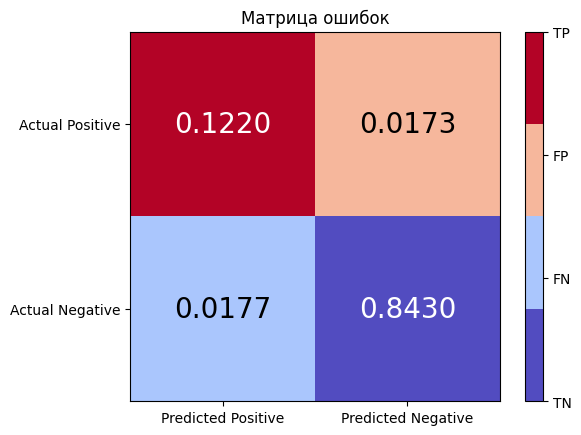

In [6]:
conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

encoded_matrix = np.array([[4, 3], [2, 1]])  

fig, ax = plt.subplots()
im = ax.imshow(encoded_matrix, cmap=cmap, vmin=1, vmax=4)  

categories = ['Predicted Positive', 'Predicted Negative']
labels = ['Actual Positive', 'Actual Negative']
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(categories)
ax.set_yticklabels(labels)

ax.text(0, 0, f"{TP:.4f}", ha="center", va="center", color="white", fontsize=20)  
ax.text(1, 0, f"{FP:.4f}", ha="center", va="center", color="black", fontsize=20)  
ax.text(0, 1, f"{FN:.4f}", ha="center", va="center", color="black", fontsize=20)  
ax.text(1, 1, f"{TN:.4f}", ha="center", va="center", color="white", fontsize=20)  

plt.title("Матрица ошибок")
cbar = plt.colorbar(im, ticks=[1, 2, 3, 4])
cbar.ax.set_yticklabels(['TN', 'FN', 'FP', 'TP']) 
plt.grid(False)
# plt.savefig('confusion_matrix_250.png', bbox_inches='tight', dpi=300)
plt.show()
